In [1]:
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import shutil

from Grafiks import to_numpy_image
from approx_attributes import *
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from captum.attr import InputXGradient,IntegratedGradients,Saliency
print(torch.__version__)
print(torchvision.__version__)

2.8.0+rocm6.4
0.23.0+rocm6.4


/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        """
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 10)
        """
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: 32x32x3
        x = F.relu(self.conv1(x))                      # -> 32x32x32
        x = F.relu(self.conv2(x))                      # -> 32x32x32
        x = F.max_pool2d(x, 2)                         # -> 16x16x32
        x = F.relu(self.conv3(x))                      # -> 16x16x64
        x = F.max_pool2d(x, 2)                         # -> 8x8x64
        x = self.flatten(x)                            # -> 4096
        x = F.relu(self.fc1(x))                        # -> 256
        x = self.fc2(x)                                # -> 10
        return x


def train_one_epoch(model, dataloader, optimizer, device):
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    i = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        i +=1
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #print(f"output: {output} target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    print(f'Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

if os.path.isfile("CifarModelCnn.pth"):

    state_dict = torch.load("CifarModelCnn.pth", map_location=torch.device(device))

    model.load_state_dict(state_dict)
    model.eval()
else:

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for x in range(10):
        train_one_epoch(model, train_loader, optimizer, device)
    torch.save(model.state_dict(), "CifarModelCnn.pth")

In [4]:
correct = 0
total = 0
for batch_idx, (data, target) in enumerate(test_loader):
    #i +=1
    data, target = data.to(device), target.to(device)

    #optimizer.zero_grad()
    output = model(data)
        #print(f"output: {output} target: {target}")
    #loss = criterion(output, target)
    #loss.backward()
    #optimizer.step()

    #total_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    total += target.size(0)

#avg_loss = total_loss / len(dataloader)
accuracy = 100. * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 60.03%


In [7]:
def to_numpy_image(attr):
    """
    Bringt Attribution Map in Shape (H,W,C) für matplotlib.
    Erwartet Tensor oder numpy array in Form:
    - (C,H,W)
    - (H,W,C)
    - (3072,)
    - (1,C,H,W)
    """
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()

    if attr.ndim == 1:  # flach: 3072
        attr = attr.reshape(3, 32, 32)

    if attr.ndim == 4:  # Batch-Format
        attr = attr.squeeze(0)  # -> (C,H,W)

    if attr.shape[0] == 3 and attr.ndim == 3:  # (C,H,W)
        attr = np.transpose(attr, (1, 2, 0))

    return attr

Grad Approx


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.4144363].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.319458].


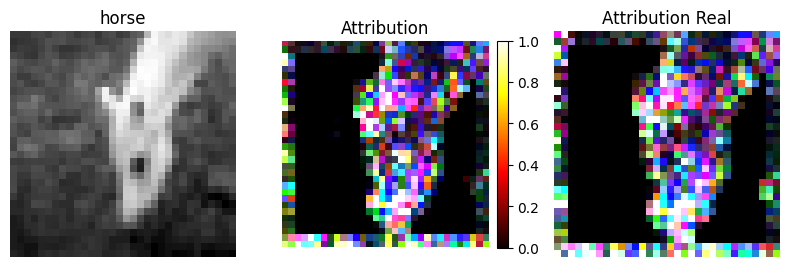

[0.980782403697249, -0.7383856141995538, 0.3604204318625119, -0.9060129939121428, 0.9177310157035766, -0.999135439753575, 0.6069156230184192, 0.46367781751741166, -0.655391703364931, -0.9926826238024776, 0.3549137088937873, -0.2068700527937022, -0.959830518161239, 0.1900190973832201, 0.8138914739512636, -0.14878195485193632, 0.9994572795022116, 0.9346493496443496, 0.4694087865484277, 0.9999241382341366, 0.7593738156228707, 0.023829148119538172, 0.8225078125589028, 0.9982614576687825, -0.6320370413701389, -0.5824904439580566, 0.999999175179527, 0.7699555909453332, 0.6027161808252739, 0.5793043340855505, 0.08501473331927455, 0.943348333216411]


In [16]:



dataset = test_loader.dataset
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}


idx = 4309 #np.random.randint(0, len(dataset) - 1)


img, label = dataset[idx]
aa =  ApproxAttribution(model)
sal = Saliency(model)
ig = IntegratedGradients(model)

image = img[0]
#attributions = np.random.rand(784)


attribution_map = to_numpy_image( aa.grad_approx(0.1,[img.unsqueeze(0)],label))

#for elem in attribution_map:
#    print(elem)
#attribution_map = aa.int_Grad_approx(0.01,0.01,1,[img],label).reshape(28, 28)

attribution_map_real = to_numpy_image( sal.attribute(img.unsqueeze(0).float().to(device), target=label).detach().cpu().numpy())
#attribution_map_real = ig.attribute(img.unsqueeze(0).float(), target=label,baselines=torch.zeros_like(img, dtype=torch.float)).detach().numpy().reshape(28, 28)


fig, axes = plt.subplots(1, 3,  figsize=(8, 4))


axes[0].imshow(image, cmap='gray')
axes[0].set_title(cifar10_labels[label])
axes[0].axis('off')


im = axes[1].imshow(attribution_map, cmap='hot')
axes[1].set_title('Attribution')
axes[1].axis('off')

im = axes[2].imshow(attribution_map_real, cmap='hot')
axes[2].set_title('Attribution Real')
axes[2].axis('off')


fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(pearson_correlation(attribution_map,attribution_map_real))
#print(sample_idx)


# Bilder bei denen grad failt: 33524 20015 13675 4926


In [11]:
idx = np.random.randint(0, len(dataset) - 1)

4309
Grad Approx


/tmp/ipykernel_6545/1377887037.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 800x400 with 4 Axes> than <Figure size 1000x400 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)


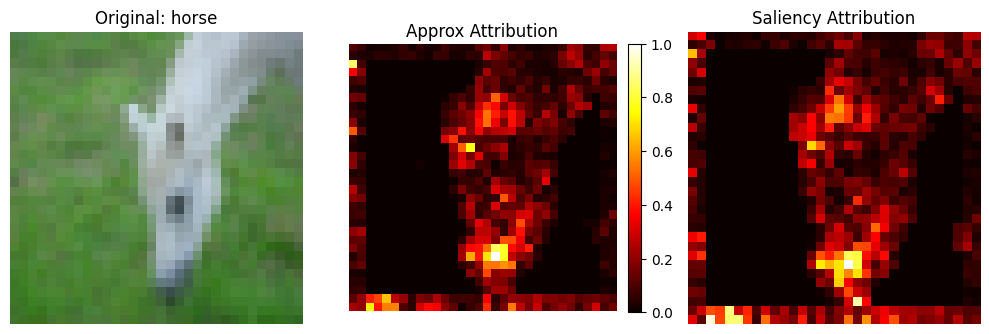

Correlation: [0.6907712649333343, 0.8187123040764319, 0.9657121821038681, 0.8758765180436558, 0.7533278019112589, 0.8029133076054683, 0.7623224624075122, 0.9329933185764103, 0.9219386071493725, 0.8944244353609517, 0.9145252086563106, 0.8509479010021931, 0.9247083698735068, 0.9022482260096644, 0.8434125972888705, 0.7029929813761845, 0.7177905351495588, 0.8660704735765187, 0.9540694080432579, 0.9572164506310463, 0.9692515051713414, 0.9254031844848961, 0.9385626532449718, 0.938123139362083, 0.9613716516059323, 0.9838661563965057, 0.9802035163541037, 0.9643348341830252, 0.8978559051727735, 0.8580955242810762, 0.8253295526700403, 0.7391239854712979]


In [17]:
# shape: [3, 32, 32]
print(idx)
img, label = dataset[idx]
aa =  ApproxAttribution(model)
sal = Saliency(model)
ig = IntegratedGradients(model)

attribution_map = aa.grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)

# Attribution mit Saliency von Captum
attribution_map_real = sal.attribute(img.unsqueeze(0).float().to(device), target=label)
attribution_map_real = attribution_map_real.squeeze().detach().cpu().numpy()  # shape: [3, 32, 32]

#(shape: [3, 32, 32] -> [32, 32, 3])
image_np = img.permute(1, 2, 0).numpy()
image_np = np.clip(image_np, 0, 1)  # für saubere Darstellung

attr_vis = np.abs(attribution_map).sum(axis=0)
attr_real_vis = np.abs(attribution_map_real).sum(axis=0)


fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(image_np)
axes[0].set_title(f'Original: {cifar10_labels[label]}')
axes[0].axis('off')

axes[1].imshow(attr_vis, cmap='hot')
axes[1].set_title('Approx Attribution')
axes[1].axis('off')

axes[2].imshow(attr_real_vis, cmap='hot')
axes[2].set_title('Saliency Attribution')
axes[2].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


print("Correlation:", pearson_correlation(attr_vis, attr_real_vis))

In [18]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

# Wähle einen zufälligen Index
idx = np.random.randint(0, len(dataset) - 1)

# Hole das Bild und Label
img, label = dataset[idx]

Using cache found in /home/benomin/.cache/torch/hub/pytorch_vision_v0.10.0
/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Grad Approx


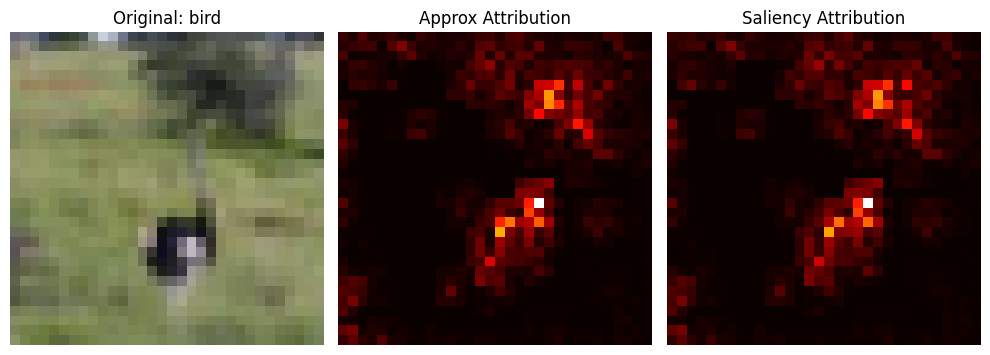

Correlation: [0.9457721049787948, 0.9973613456052951, 0.9052814247166592, 0.9663650165581693, 0.891985122041454, 0.9642091246140442, 0.9908192553236388, 0.9991599698647345, 0.9988321478652901, 0.9953368621740079, 0.9883450163599949, 0.9780903197961431, 0.9962166462995816, 0.9962529511589316, 0.9923354966001502, 0.9996898917091964, 0.9999862003354756, 0.9999536179619279, 0.9986461924943126, 0.9763842933470943, 0.9884108248915613, 0.9909099718853203, 0.9998852802384289, 0.992654815282059, 0.9911123212932437, 0.9981182878449673, 0.998318605551207, 0.9993472018342862, 0.9972888522890543, 0.8026056495508852, 0.9984009100865548, 0.977688552180124]


In [19]:
# shape: [3, 32, 32]
img, label = dataset[idx]


attribution_map = aa.grad_approx(0.01, [img.unsqueeze(0)], label).reshape(3, 32, 32)


attribution_map_real = sal.attribute(img.unsqueeze(0).float(), target=label)
attribution_map_real = attribution_map_real.squeeze().detach().numpy()  # shape: [3, 32, 32]

# shape: [3, 32, 32] -> [32, 32, 3]
image_np = img.permute(1, 2, 0).numpy()
image_np = np.clip(image_np, 0, 1)


attr_vis = np.abs(attribution_map).sum(axis=0)
attr_real_vis = np.abs(attribution_map_real).sum(axis=0)


fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(image_np)
axes[0].set_title(f'Original: {cifar10_labels[label]}')
axes[0].axis('off')

axes[1].imshow(attr_vis, cmap='hot')
axes[1].set_title('Approx Attribution')
axes[1].axis('off')

axes[2].imshow(attr_real_vis, cmap='hot')
axes[2].set_title('Saliency Attribution')
axes[2].axis('off')

plt.tight_layout()
plt.show()


print("Correlation:", pearson_correlation(attr_vis, attr_real_vis))